In [3]:
# use wandb artifact outside a run

import wandb

api = wandb.Api()
artifact = api.artifact('greatml/FedSPK/Artifact0.8790510733321198:v0')

datadir = artifact.download()


wandb:   1 of 1 files downloaded.  


In [4]:
import torch

def loadParameters(model, path, map_location="cuda:0"):

    self_state = model.state_dict()
    loaded_state = torch.load(path, map_location=map_location)

    for name, param in loaded_state.items():
        if '__L__.W' in name:
            continue

        origname = name
        if name not in self_state:
            name = name.replace("module.", "")
            if name not in self_state:
                name = "__S__."+name
                if name not in self_state:
                    print("#%s is not in the model." % origname)
                    continue

        if self_state[name].size() != loaded_state[origname].size():
            print("#Wrong parameter length: %s, model: %s, loaded: %s" % (
                origname, self_state[name].size(), loaded_state['model'][origname].size()))
            continue

        self_state[name].copy_(param)

In [5]:
# %%
import time
from src.DatasetLoader import loadWAV
import os
import sys


def evaluateFromList(model, listfilename, print_interval=100, test_path='', num_eval=10, eval_frames=0, verbose=True):

    model = model.cuda()

    model.eval()

    labels = []
    files = []
    feats = []
    tstart = time.time()

    # Read all lines
    with open(listfilename) as listfile:
        while True:
            line = listfile.readline()
            if (not line):
                break

            data = line.split()

            files.append(data[1])
            labels.append(data[0])

    f_labels = []
    # Save all features to file
    for idx, (file, label) in enumerate(zip(files, labels)):

        inp1 = torch.FloatTensor(loadWAV(os.path.join(
            test_path, file), eval_frames, evalmode=True, num_eval=num_eval)).cuda()

        try:
            ref_feat = model.forward(inp1).detach().cpu()
        except:
            print("Error in file: ", file)
            continue

        feats.append(ref_feat)
        f_labels.append(label)

        telapsed = time.time() - tstart

        if (idx % print_interval == 0) and verbose:
            sys.stdout.write("\rReading %d of %d: %.2f Hz, embedding size %d" % (
                idx, len(files), idx/telapsed, ref_feat.size()[1]))

    tstart = time.time()

    return feats, f_labels


In [12]:
def generate_dictkeys(input_file):
    ### Read Training Files...
    with open(input_file) as dataset_file:
        lines = dataset_file.readlines()

    dictkeys = list(set([x.split()[0] for x in lines]))
    dictkeys.sort()
    dictkeys = { key : ii for ii, key in enumerate(dictkeys) }
    # len_dictkeys_ori = len(dictkeys)

    label_dict = {}
    data_list  = []
    data_label = []

    lidx = 0
    for _, line in enumerate(lines):
        data = line.strip().split()

        speaker_label = dictkeys[data[0]]
        filename = os.path.join('', data[1])

        if not (speaker_label in label_dict):
            label_dict[speaker_label] = []

        label_dict[speaker_label].append(lidx)
        
        data_label.append(speaker_label)
        data_list.append(filename)

        lidx += 1

    return dictkeys

In [7]:
dictkeys = generate_dictkeys('/workspace/flearn_data/IDtrain_list_G2.txt')

In [8]:
from src.DatasetLoader import get_data_loader_speaker

dataloader = get_data_loader_speaker(0, dataset_file_name='/workspace/flearn_data/IDtrain_list_G2.txt', 
        batch_size=128, augment=False, musan_path='/nvme/zhiyong/musan_split', 
        rir_path='/nvme/zhiyong/RIRS_NOISES/simulated_rirs', max_frames=300, 
        max_seg_per_spk=100, nDataLoaderThread=8, nPerSpeaker=1, 
        train_path='', sox_aug=False)

In [9]:
# %%
from src.SpeakerNet import SpeakerNet

model = SpeakerNet(model='X_vector', trainfunc='softmax', nPerSpeaker=1, Syncbatch=False,
                   n_mels=40, nOut=192, spec_aug=False, nClasses=5994, additional_model=[True, False], ID_task=len(dictkeys))


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


In [29]:
# %%
loadParameters(model, datadir +
               '/STD: std_FL test compact testing, canoical.pth')


In [25]:
list(model.state_dict().keys())

['__S__.torchfb.0.flipped_filter',
 '__S__.torchfb.1.spectrogram.window',
 '__S__.torchfb.1.mel_scale.fb',
 '__S__.tdnn1.0.weight',
 '__S__.tdnn1.0.bias',
 '__S__.tdnn1.2.weight',
 '__S__.tdnn1.2.bias',
 '__S__.tdnn1.2.running_mean',
 '__S__.tdnn1.2.running_var',
 '__S__.tdnn1.2.num_batches_tracked',
 '__S__.tdnn2.0.weight',
 '__S__.tdnn2.0.bias',
 '__S__.tdnn2.2.weight',
 '__S__.tdnn2.2.bias',
 '__S__.tdnn2.2.running_mean',
 '__S__.tdnn2.2.running_var',
 '__S__.tdnn2.2.num_batches_tracked',
 '__S__.tdnn3.0.weight',
 '__S__.tdnn3.0.bias',
 '__S__.tdnn3.2.weight',
 '__S__.tdnn3.2.bias',
 '__S__.tdnn3.2.running_mean',
 '__S__.tdnn3.2.running_var',
 '__S__.tdnn3.2.num_batches_tracked',
 '__S__.tdnn4.0.weight',
 '__S__.tdnn4.0.bias',
 '__S__.tdnn4.2.weight',
 '__S__.tdnn4.2.bias',
 '__S__.tdnn4.2.running_mean',
 '__S__.tdnn4.2.running_var',
 '__S__.tdnn4.2.num_batches_tracked',
 '__S__.tdnn5.0.weight',
 '__S__.tdnn5.0.bias',
 '__S__.tdnn5.2.weight',
 '__S__.tdnn5.2.bias',
 '__S__.tdnn5.2.r

In [10]:
def client_update(model, dataloader, epoch=10, id=1, wandb_run=None):
    """Update local model using local dataset."""
    model.train()
    model.to('cuda')
    step_count = 0


    optimizer = torch.optim.SGD(model._SpeakerNet__L__ID.parameters(), lr = 1e-2, momentum = 0.9, weight_decay=5e-4)
    
    for e in range(epoch):
        loss_total = 0
        prec_total = 0
        counter = 0
        for data, data_label in dataloader:
            step_count += 1

            # data, labels = data.float().to(self.device), labels.long().to(self.device)
            data    = data.transpose(1,0)
            label   = torch.LongTensor(data_label).cuda()

            optimizer.zero_grad()

            loss, prec = model(data, label)

            loss.backward()
            optimizer.step()

            loss_total += loss.detach().cpu().numpy()
            prec_total += prec.detach().cpu().numpy()
            counter += 1
            sys.stdout.write("Epoch %d Step %f Loss %f Prec %f\r"%(e+1, step_count, loss_total/counter, prec_total/counter))
            sys.stdout.flush()
            
            torch.cuda.empty_cache()
    
    # create a directory
    pth_dir = '/workspace/FL_log/'+wandb_run.notes
    if not os.path.exists(pth_dir):
        os.makedirs(pth_dir)
    
    # save the model
    torch.save(model.state_dict(), pth_dir+'/ID_model%d.pth'%id)

    # create a wandb run and upload the pth to wandb using artifacts
    
    artifact = wandb.Artifact('ID_model%d'%id, type='model', description=wandb_run.notes)
    artifact.add_file(pth_dir+'/ID_model%d.pth'%id)
    wandb_run.log_artifact(artifact)

In [11]:
def train_id_model(model_path, train_dataset, id, wandb_run):
    dictkeys = generate_dictkeys(train_dataset)

    dataloader = get_data_loader_speaker(0, dataset_file_name=train_dataset, 
            batch_size=128, augment=False, musan_path='/nvme/zhiyong/musan_split', 
            rir_path='/nvme/zhiyong/RIRS_NOISES/simulated_rirs', max_frames=300, 
            max_seg_per_spk=100, nDataLoaderThread=8, nPerSpeaker=1, 
            train_path='', sox_aug=False)
    
    model = SpeakerNet(model='X_vector', trainfunc='softmax', nPerSpeaker=1, Syncbatch=False,
                    n_mels=40, nOut=192, spec_aug=False, nClasses=5994, additional_model=[True, False], ID_task=len(dictkeys))
    
    loadParameters(model, model_path)

    client_update(model, dataloader, epoch=100, id=id, wandb_run=wandb_run)
    

In [30]:
client_update(model, dataloader, epoch=100)

In [25]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="FedSPK",
    notes="ID_models for STD: std_FL test compact testing, canoical.pth",
    job_type="upload-artifacts",
    tags="model_artifacts",
    dir='/nvme/zhiyong/wandb'
)

for i in range(12):
    train_id_model('/workspace/FedSPK/artifacts/Artifact0.8790510733321198:v0/STD: std_FL test compact testing, canoical.pth',
                   '/workspace/flearn_data/IDtrain_list_G%d.txt' % (i+1), id=(i+1), wandb_run=run)
    print('')

run.finish()

X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss
Epoch 100 Step 600.000000 Loss 0.539701 Prec 98.958336
X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss
Epoch 100 Step 600.000000 Loss 1.592638 Prec 83.333336
X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss
Epoch 100 Step 600.000000 Loss 0.637071 Prec 98.5677110
X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss
Epoch 100 Step 600.000000 Loss 1.449087 Prec 86.328125
X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss
Epoch 100 Step 600.000000 Loss 0.608580 Prec 98.697914
X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss
Epoch 100 Step 600.000000 Loss 1.214664 Prec 91.015625
X_vector.py, Embedding size is 192,  Spec_aug False

In [26]:
run.finish()

In [12]:
run = wandb.init(
    # set the wandb project where this run will be logged
    project="FedSPK",
    notes="ID_models for STD: centerized training.pth",
    job_type="upload-artifacts",
    tags="model_artifacts",
    dir='/nvme/zhiyong/wandb'
)

for i in range(12):
    train_id_model('/workspace/FedSPK/artifacts/Artifact0.9596814134430157:v0/STD: centerized training.pth',
                   '/workspace/flearn_data/IDtrain_list_G%d.txt' % (i+1), id=(i+1), wandb_run=run)
    print('')

run.finish()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bicbrv (greatml). Use `wandb login --relogin` to force relogin


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss
Epoch 100 Step 600.000000 Loss 0.601351 Prec 99.739586
X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss
Epoch 100 Step 600.000000 Loss 2.426138 Prec 77.864586
X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss
Epoch 100 Step 600.000000 Loss 0.952514 Prec 99.218750
X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss
Epoch 100 Step 600.000000 Loss 2.483494 Prec 66.796875
X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss
Epoch 100 Step 600.000000 Loss 0.876013 Prec 99.4791640
X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss
Epoch 100 Step 600.000000 Loss 2.202363 Prec 76.692711
X_vector.py, Embedding size is 192,  Spec_aug False

## Evaluate ID

In [14]:
import time
from src.DatasetLoader import loadWAV
import os
import sys
import torch
import tqdm
import numpy as np

def test_id_model(model_path, test_dataset, output_path='', id=None, wandb_run=None):
    dictkeys = generate_dictkeys(test_dataset)
    
    model = SpeakerNet(model='X_vector', trainfunc='softmax', nPerSpeaker=1, Syncbatch=False,
                    n_mels=40, nOut=192, spec_aug=False, nClasses=5994, additional_model=[True, False], ID_task=len(dictkeys))
    
    # load the model
    model.load_state_dict(torch.load(model_path))

    model.eval()
    model.to('cuda')

    # read lines from test_dataset
    with open(test_dataset, 'r') as f:
        lines = f.readlines()

    output_prob = []
    label_list = []

    # tqdm to iterate lines
    for idx, line in tqdm.tqdm(enumerate(lines)):
        # get the file name and label
        label, file = line.strip().split(' ')

        inp1 = torch.FloatTensor(loadWAV(file, max_frames=0, evalmode=True)).cuda()

        try:
            softmax_x_output = model.forward(inp1).detach().cpu().numpy()
        except:
            print("Error in file: ", file)
            continue

        output_prob.append(softmax_x_output)
        label_list.append(label)
    
    print('total_line:', (idx+1))

    # combine the output_prob list to numpy array
    output_prob = np.concatenate(output_prob, axis=0)

    # convert label_list to numpy array
    label_list = np.array(label_list)

    # create the output_path if not exist
    if output_path != '':
        if not os.path.exists(output_path):
            os.makedirs(output_path)

    # save the output_prob and label_list to output_path
    if output_path != '':
        np.save(os.path.join(output_path, 'ID_output_prob%d.npy'%id), output_prob)
        np.save(os.path.join(output_path, 'ID_label_list%d.npy'%id), label_list)
    
    # upload the output_prob and label_list to wandb using artifacts using wandb_run
    if wandb_run is not None:
        artifact = wandb.Artifact('ID_output_prob%d'%id, type='model', description=wandb_run.notes)
        artifact.add_file(output_path+'/ID_output_prob%d.npy'%id)
        wandb_run.log_artifact(artifact)

        artifact = wandb.Artifact('ID_label_list%d'%id, type='model', description=wandb_run.notes)
        artifact.add_file(output_path+'/ID_label_list%d.npy'%id)
        wandb_run.log_artifact(artifact)

In [44]:
a = wandb.Api().runs("FedSPK")

In [46]:
a= list(a)

In [55]:
a[0].id

'd8o003qc'

In [57]:
a[0].notes

'ID_models for STD: centerized training.pth'

In [58]:
a[1].id

'5xrhheai'

In [59]:
a[1].notes

'ID_models for STD: std_FL test compact testing, canoical.pth'

In [62]:
# get ID eval results for "ID_models for STD: std_FL test compact testing, canoical.pth"

import os
import wandb
run = wandb.init(
    id="5xrhheai",
    resume="must"
)


for i in range(12):
    api = wandb.Api()
    artifact = api.artifact('greatml/FedSPK/ID_model%d:v0' % (i+1))

    datadir = artifact.download()

    test_id_model(os.path.join(datadir, 'ID_model%d.pth' % (i+1)),
                  '/workspace/flearn_data/IDeval_list_G%d.txt' % (i+1), output_path='/workspace/FL_log/ID_models for STD: std_FL test compact testing, canoical.pth', id=(i+1), wandb_run=run)


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


4074it [00:58, 69.62it/s]


total_line: 4074


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


4074it [00:54, 75.23it/s] 


total_line: 4074


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


4074it [00:48, 83.58it/s] 


total_line: 4074


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


4074it [00:49, 82.04it/s] 


total_line: 4074


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


4074it [00:51, 79.12it/s] 


total_line: 4074


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


4074it [00:47, 85.13it/s] 


total_line: 4074


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


12325it [02:19, 10.11it/s] 

Error in file:  /nvme/zhiyong/fllearn_data/G7_ID/id00325_speech-06-004.wav


14478it [02:44, 87.87it/s] 


total_line: 14478


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


12330it [02:27, 29.29it/s] 

Error in file:  /nvme/zhiyong/fllearn_data/G8_ID/id00325_speech-06-004.wav


14478it [02:55, 82.69it/s] 


total_line: 14478


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


12328it [02:24, 31.63it/s] 

Error in file:  /nvme/zhiyong/fllearn_data/G9_ID/id00325_speech-06-004.wav


14478it [02:47, 86.31it/s] 


total_line: 14478


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


12330it [02:26, 32.05it/s] 

Error in file:  /nvme/zhiyong/fllearn_data/G10_ID/id00325_speech-06-004.wav


14478it [02:51, 84.63it/s] 


total_line: 14478


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


12328it [02:17, 44.80it/s] 

Error in file:  /nvme/zhiyong/fllearn_data/G11_ID/id00325_speech-06-004.wav


14478it [02:40, 90.44it/s] 


total_line: 14478


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


12325it [02:16, 30.21it/s] 

Error in file:  /nvme/zhiyong/fllearn_data/G12_ID/id00325_speech-06-004.wav


14478it [02:40, 90.45it/s] 


total_line: 14478


In [63]:
# get ID eval results for 'ID_models for STD: centerized training.pth'

import os
import wandb
run = wandb.init(
    id="d8o003qc",
    resume="must"
)


for i in range(12):
    api = wandb.Api()
    artifact = api.artifact('greatml/FedSPK/ID_model%d:v1' % (i+1))

    datadir = artifact.download()

    test_id_model(os.path.join(datadir, 'ID_model%d.pth' % (i+1)),
                  '/workspace/flearn_data/IDeval_list_G%d.txt' % (i+1), output_path='/workspace/FL_log/ID_models for STD: centerized training.pth', id=(i+1), wandb_run=run)


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


4074it [00:38, 106.91it/s]


total_line: 4074


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


4074it [00:40, 101.48it/s]


total_line: 4074


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


4074it [00:36, 110.63it/s]


total_line: 4074


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


4074it [00:37, 107.41it/s]


total_line: 4074


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


4074it [00:36, 111.76it/s]


total_line: 4074


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


4074it [00:36, 111.43it/s]


total_line: 4074


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


12331it [01:38, 48.44it/s] 

Error in file:  /nvme/zhiyong/fllearn_data/G7_ID/id00325_speech-06-004.wav


14478it [01:54, 126.10it/s]


total_line: 14478


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


12333it [01:53, 41.34it/s] 

Error in file:  /nvme/zhiyong/fllearn_data/G8_ID/id00325_speech-06-004.wav


14478it [02:13, 108.41it/s]


total_line: 14478


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


12339it [01:41, 51.11it/s] 

Error in file:  /nvme/zhiyong/fllearn_data/G9_ID/id00325_speech-06-004.wav


14478it [01:59, 121.34it/s]


total_line: 14478


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


12331it [01:46, 52.56it/s] 

Error in file:  /nvme/zhiyong/fllearn_data/G10_ID/id00325_speech-06-004.wav


14478it [02:05, 114.95it/s]


total_line: 14478


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


12322it [01:45, 56.74it/s] 

Error in file:  /nvme/zhiyong/fllearn_data/G11_ID/id00325_speech-06-004.wav


14478it [02:03, 116.85it/s]


total_line: 14478


wandb:   1 of 1 files downloaded.  


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss
Initialised Softmax Loss


12333it [01:45, 43.00it/s] 

Error in file:  /nvme/zhiyong/fllearn_data/G12_ID/id00325_speech-06-004.wav


14478it [02:03, 117.24it/s]


total_line: 14478


## Draw ROC curve

In [36]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt


# # generate random y_test
# y_test = np.random.randint(0, 3, size=100)

# # generate random y_score for 3 classes, which sum to 1.0
# y_score = np.random.rand(100, 3)
# y_score /= y_score.sum(axis=1)[:, np.newaxis]

def plot_roc_curve(y_test, y_score, class_num):
    # Binarize the output
    y_test_bin = label_binarize(y_test, classes=[i for i in range(class_num)])
    n_classes = y_test_bin.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot micro and macro ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=1)

    # plt.plot(fpr["macro"], tpr["macro"],
    #         label='macro-average ROC curve (area = {0:0.2f})'
    #             ''.format(roc_auc["macro"]),
    #         color='navy', linestyle=':', linewidth=1)

    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro and Macro ROC curves for multi-class classification')
    plt.legend(loc="lower right")
    plt.show()

    return fpr, tpr, roc_auc

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


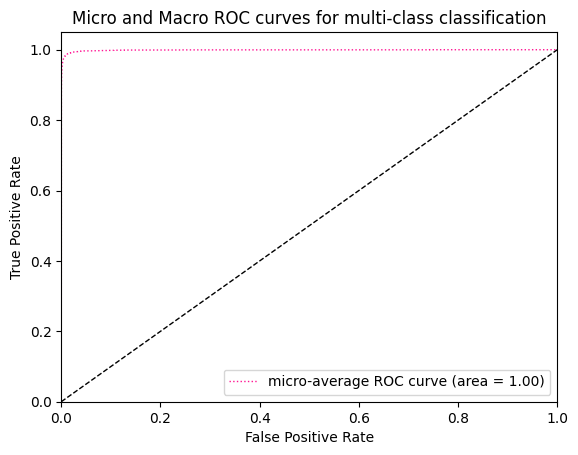

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


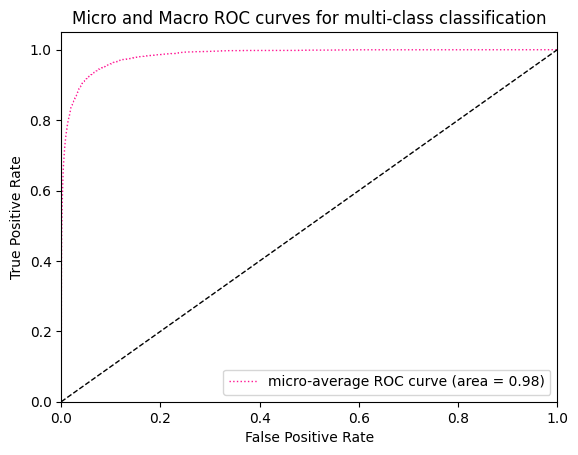

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


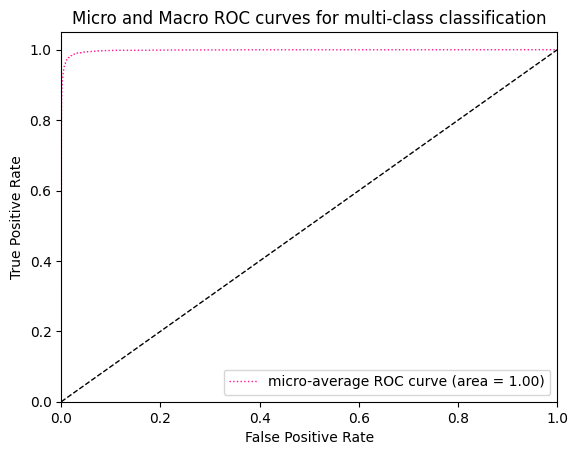

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


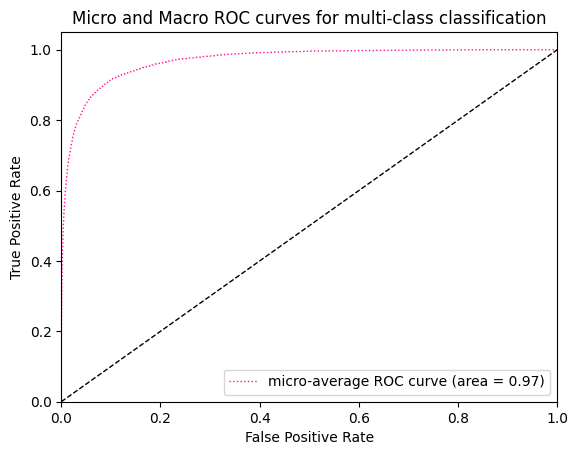

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


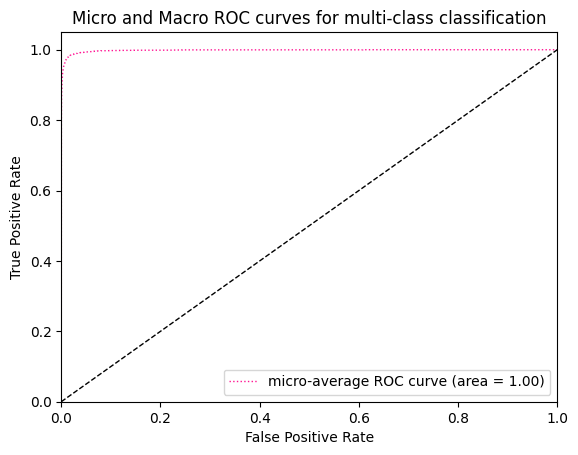

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


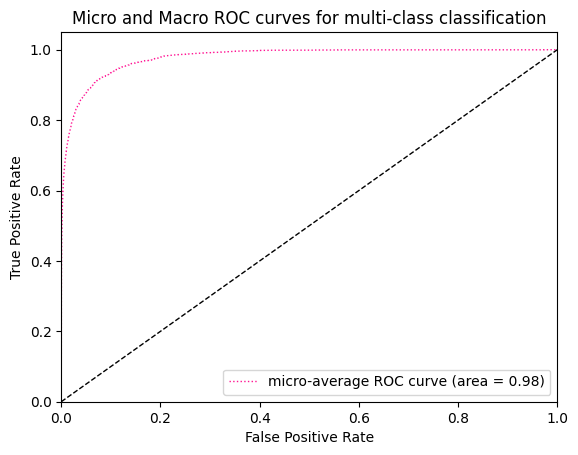

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


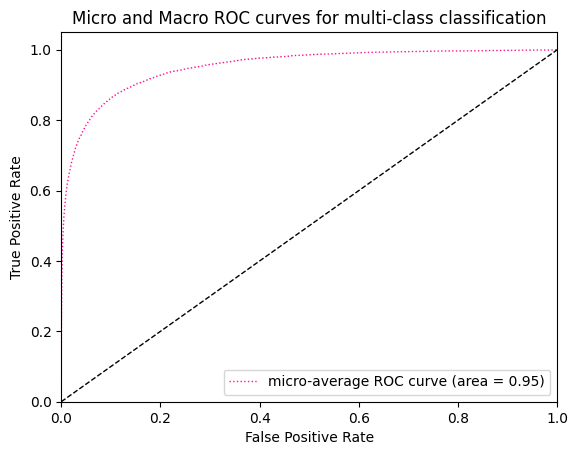

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


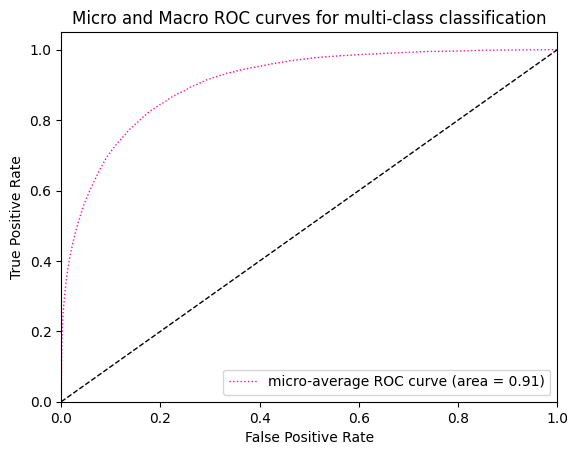

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


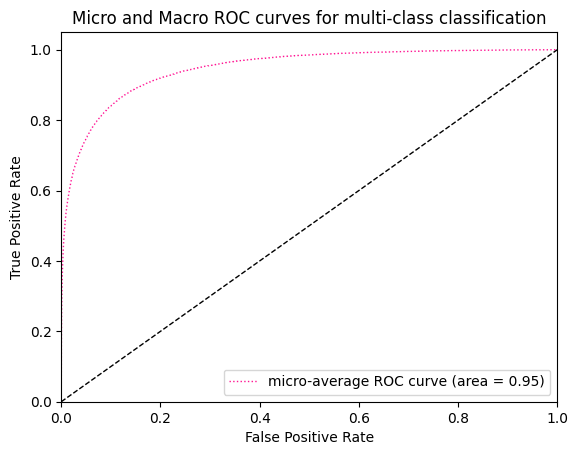

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


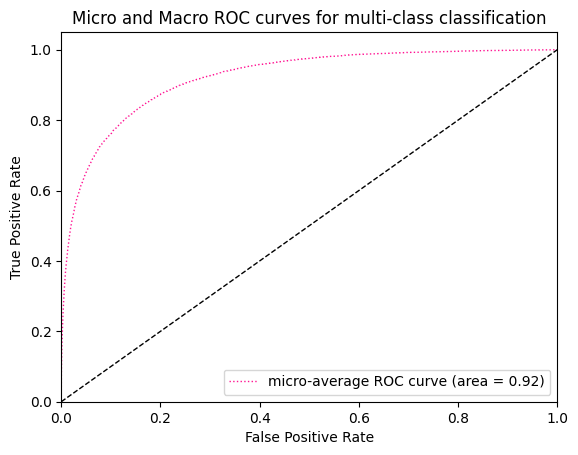

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


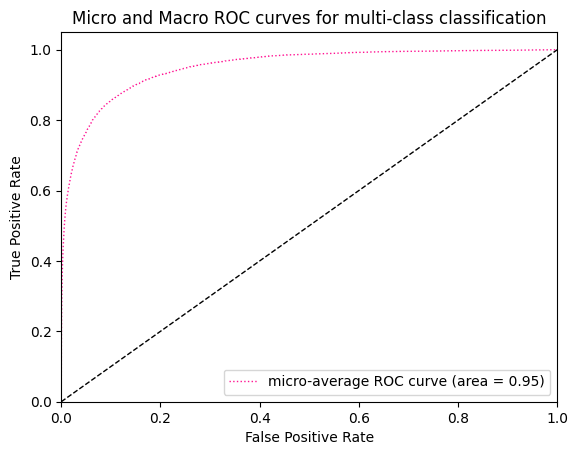

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


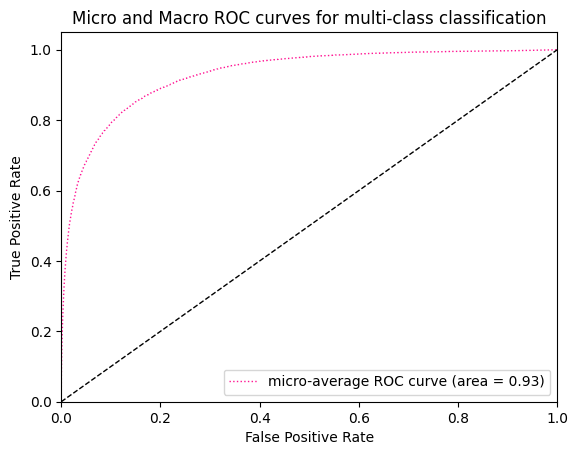

In [38]:
# result for "ID_models for STD: std_FL test compact testing, canoical.pth"
result_dict_1 = {}

for idx_l in range(12):
    # downloads wandb artifacts to local
    import wandb

    api = wandb.Api()
    artifact = api.artifact('greatml/FedSPK/ID_output_prob%d:v0'%(idx_l+1))

    datadir = artifact.download()

    # read the numpy array from the downloaded file
    import numpy as np
    a = np.load(datadir+'/ID_output_prob%d.npy'%(idx_l+1))

    # downloads the label
    import wandb

    api = wandb.Api()
    artifact = api.artifact('greatml/FedSPK/ID_label_list%d:v0'%(idx_l+1))

    datadir = artifact.download()

    # read the numpy array from the downloaded file
    import numpy as np
    b = np.load(datadir+'/ID_label_list%d.npy'%(idx_l+1))

    dictkeys = generate_dictkeys("/workspace/flearn_data/IDtrain_list_G%d.txt"%(idx_l+1))

    # create a numpy int array
    c = np.zeros(len(b), dtype=int)

    for idx, i in enumerate(b):
        c[idx] = dictkeys[i]

    # get the roc
    fpr, tpr, roc_auc = plot_roc_curve(c, a, len(dictkeys))

    result_dict_1['G%d' % (idx_l+1)] = [fpr, tpr, roc_auc]


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


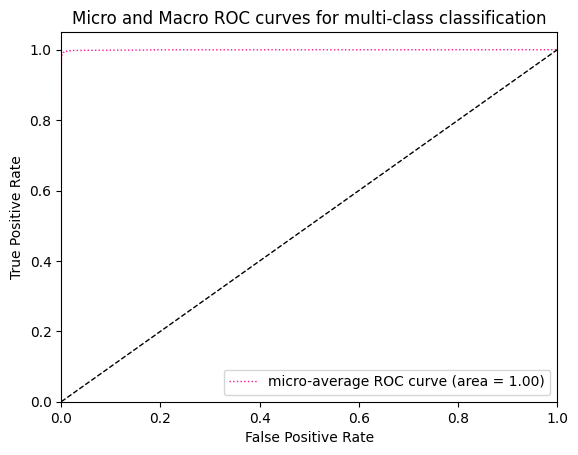

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


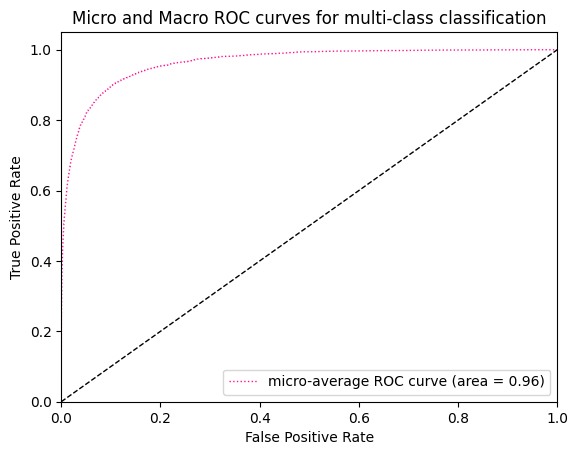

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


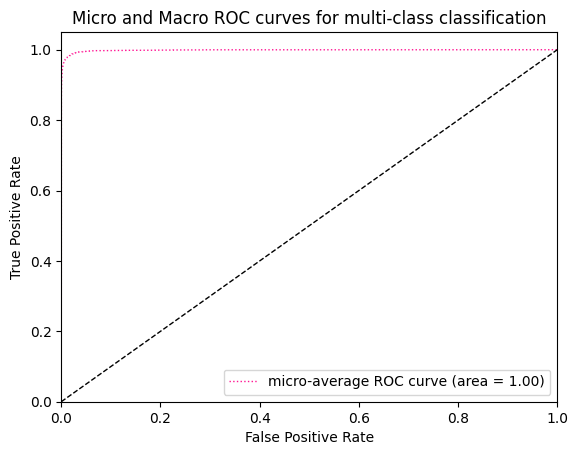

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


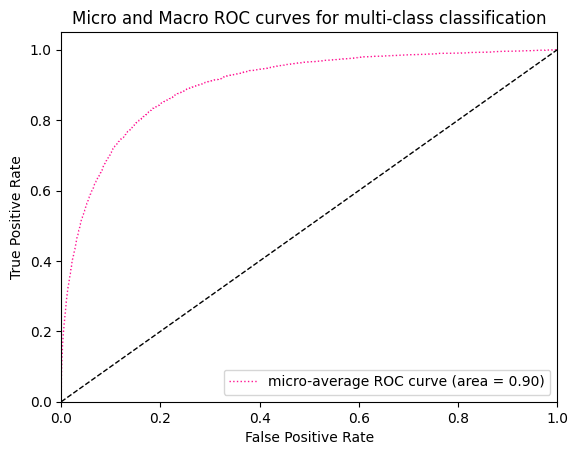

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


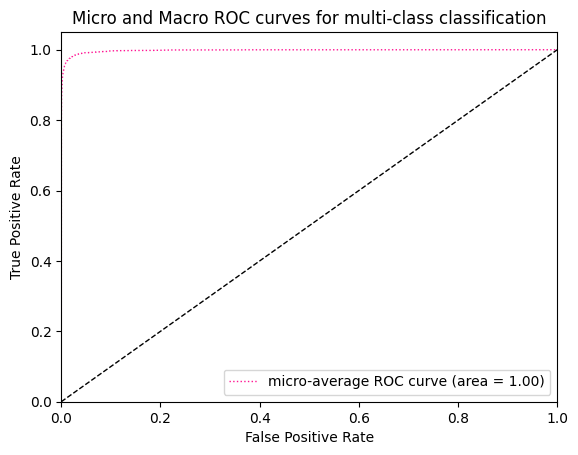

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


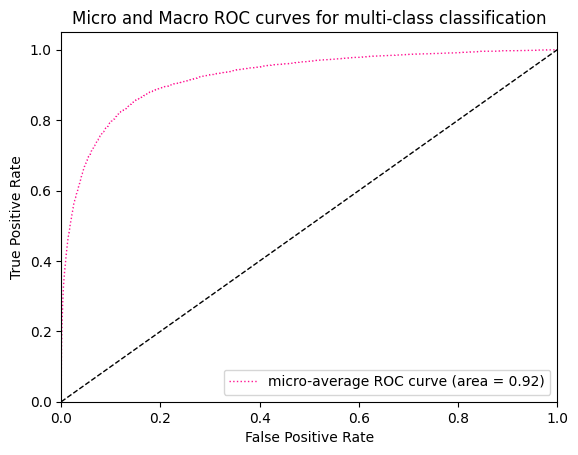

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


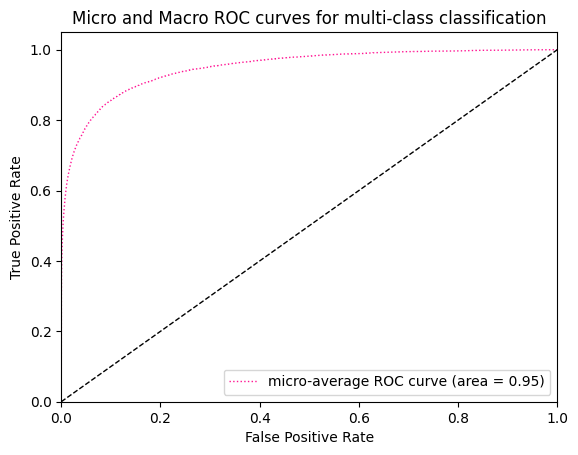

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


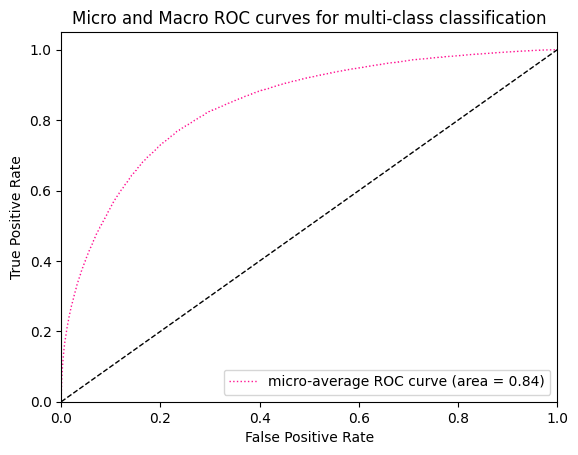

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


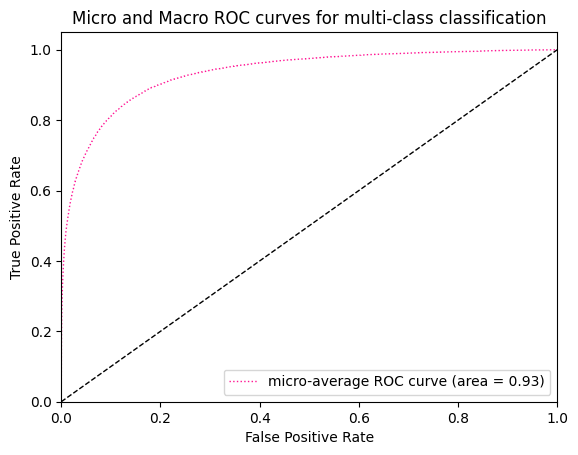

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


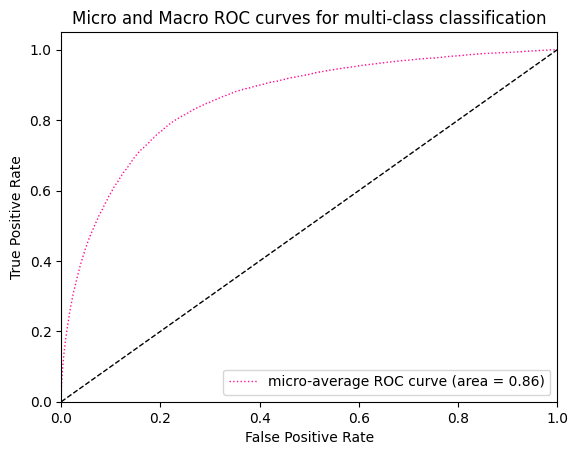

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


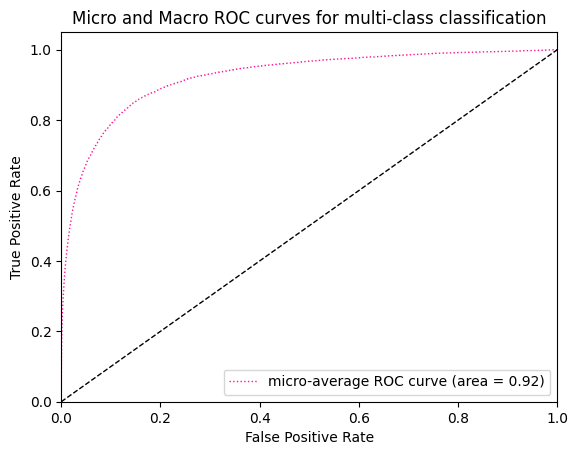

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


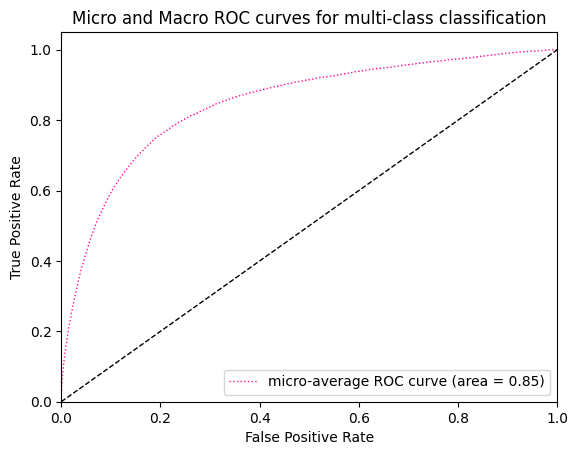

In [39]:
# result for "ID_models for STD: centerized training.pth"
result_dict_2 = {}

for idx_l in range(12):
    # downloads wandb artifacts to local
    import wandb

    api = wandb.Api()
    artifact = api.artifact('greatml/FedSPK/ID_output_prob%d:v1'%(idx_l+1))

    datadir = artifact.download()

    # read the numpy array from the downloaded file
    import numpy as np
    a = np.load(datadir+'/ID_output_prob%d.npy'%(idx_l+1))

    # downloads the label
    import wandb

    api = wandb.Api()
    artifact = api.artifact('greatml/FedSPK/ID_label_list%d:v0'%(idx_l+1))

    datadir = artifact.download()

    # read the numpy array from the downloaded file
    import numpy as np
    b = np.load(datadir+'/ID_label_list%d.npy'%(idx_l+1))

    dictkeys = generate_dictkeys("/workspace/flearn_data/IDtrain_list_G%d.txt"%(idx_l+1))

    # create a numpy int array
    c = np.zeros(len(b), dtype=int)

    for idx, i in enumerate(b):
        c[idx] = dictkeys[i]

    # get the roc
    fpr, tpr, roc_auc = plot_roc_curve(c, a, len(dictkeys))

    result_dict_2['G%d' % (idx_l+1)] = [fpr, tpr, roc_auc]


In [52]:
len(result_dict_2['G5'][1]['micro'])

2441

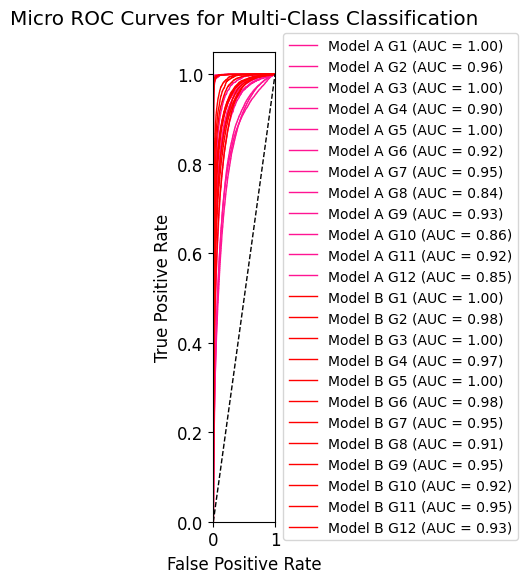

In [59]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, auc, model_name, group, color, linestyle='-'):
    plt.plot(fpr, tpr,
             label=f'{model_name} G{group} (AUC = {auc:.2f})',
             color=color, linestyle=linestyle, linewidth=1)

plt.figure(figsize=(6, 6))
plt.rcParams.update({'font.size': 12})

# Plot Model A ROC curves
for i in range(12):
    fpr, tpr, auc = result_dict_2[f'G{i+1}'][0]['micro'], result_dict_2[f'G{i+1}'][1]['micro'], result_dict_2[f'G{i+1}'][2]['micro']
    plot_roc_curve(fpr, tpr, auc, 'Model A', i+1, 'deeppink')

# Plot Model B ROC curves
for i in range(12):
    fpr, tpr, auc = result_dict_1[f'G{i+1}'][0]['micro'], result_dict_1[f'G{i+1}'][1]['micro'], result_dict_1[f'G{i+1}'][2]['micro']
    plot_roc_curve(fpr, tpr, auc, 'Model B', i+1, 'red')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro ROC Curves for Multi-Class Classification', pad=20)

# Place the legend outside the plot area and adjust the column spacing
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), ncol=1, fontsize='small', columnspacing=0.5)

plt.tight_layout(rect=[0, 0, 0.68, 1])  # Adjust the width of the plot to make room for the legend
plt.savefig('roc_curves_paper.png', dpi=300)
plt.show()


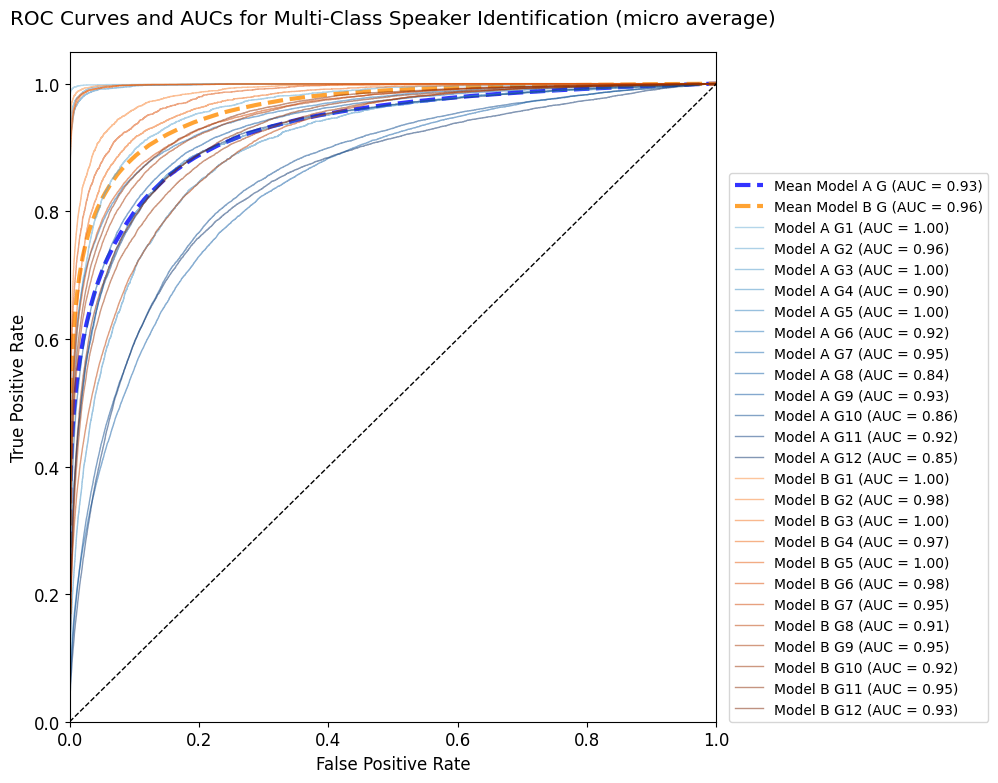

In [79]:
from sklearn.metrics import auc
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': 12})

# Compute mean ROC curve and AUC
def mean_roc(result_dict):
    mean_fpr = np.linspace(0, 1, 1000)
    tprs = []
    aucs = []

    for i in range(12):
        fpr, tpr = result_dict[f'G{i+1}'][0]['micro'], result_dict[f'G{i+1}'][1]['micro']
        interp_tpr = interp1d(fpr, tpr, kind='linear', fill_value=(0, 1), bounds_error=False)(mean_fpr)
        tprs.append(interp_tpr)
        aucs.append(result_dict[f'G{i+1}'][2]['micro'])

    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    return mean_fpr, mean_tpr, mean_auc

def plot_roc_curve(fpr, tpr, auc, model_name, group, color, linestyle='-', alpha=0.5, linewidth=1):
    plt.plot(fpr, tpr,
             label=f'{model_name} G{group} (AUC = {auc:.2f})',
             color=color, linestyle=linestyle, linewidth=linewidth, alpha=alpha)

mean_fpr_A, mean_tpr_A, mean_auc_A = mean_roc(result_dict_2)
mean_fpr_B, mean_tpr_B, mean_auc_B = mean_roc(result_dict_1)

# Plot mean ROC curves with increased line width and changed line style
plot_roc_curve(mean_fpr_A, mean_tpr_A, mean_auc_A, 'Mean Model A', '', 'blue', linestyle='--', alpha=0.8, linewidth=3)
plot_roc_curve(mean_fpr_B, mean_tpr_B, mean_auc_B, 'Mean Model B', '', 'darkorange', linestyle='--', alpha=0.8, linewidth=3)

# Existing code for plotting individual ROC curves...


# Generate colors for Model A and Model B
colors_A = plt.cm.Blues(np.linspace(0.5, 1, 12))
colors_B = plt.cm.Oranges(np.linspace(0.5, 1, 12))

# Plot Model A ROC curves
for i in range(12):
    fpr, tpr, auc = result_dict_2[f'G{i+1}'][0]['micro'], result_dict_2[f'G{i+1}'][1]['micro'], result_dict_2[f'G{i+1}'][2]['micro']
    plot_roc_curve(fpr, tpr, auc, 'Model A', i+1, colors_A[i])

# Plot Model B ROC curves
for i in range(12):
    fpr, tpr, auc = result_dict_1[f'G{i+1}'][0]['micro'], result_dict_1[f'G{i+1}'][1]['micro'], result_dict_1[f'G{i+1}'][2]['micro']
    plot_roc_curve(fpr, tpr, auc, 'Model B', i+1, colors_B[i])

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves and AUCs for Multi-Class Speaker Identification (micro average)', pad=20)

# Add the mean AUC values to the legend
plt.legend(loc="lower left", bbox_to_anchor=(1.02, 0), fontsize='small', ncol=1, borderaxespad=0)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('roc_curves_paper.png', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(fpr, tpr, auc, model_name, group, color, linestyle='-', alpha=0.5):
    plt.plot(fpr, tpr,
             label=f'{model_name} G{group} (AUC = {auc:.2f})',
             color=color, linestyle=linestyle, linewidth=1, alpha=alpha)

plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 12})

# Generate colors for Model A and Model B
colors_A = plt.cm.Blues(np.linspace(0.5, 1, 12))
colors_B = plt.cm.Oranges(np.linspace(0.5, 1, 12))

# Plot Model A ROC curves
for i in range(12):
    fpr, tpr, auc = result_dict_2[f'G{i+1}'][0]['micro'], result_dict_2[f'G{i+1}'][1]['micro'], result_dict_2[f'G{i+1}'][2]['micro']
    plot_roc_curve(fpr, tpr, auc, 'Model A', i+1, colors_A[i])

# Plot Model B ROC curves
for i in range(12):
    fpr, tpr, auc = result_dict_1[f'G{i+1}'][0]['micro'], result_dict_1[f'G{i+1}'][1]['micro'], result_dict_1[f'G{i+1}'][2]['micro']
    plot_roc_curve(fpr, tpr, auc, 'Model B', i+1, colors_B[i])

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro ROC Curves for Multi-Class Classification', pad=20)

# Place the legend outside the plot area and adjust column width
legend = plt.legend(loc="lower left", bbox_to_anchor=(1.02, 0), fontsize='small', ncol=1, borderaxespad=0)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the padding to accommodate the legend
plt.savefig('roc_curves_paper.png', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()

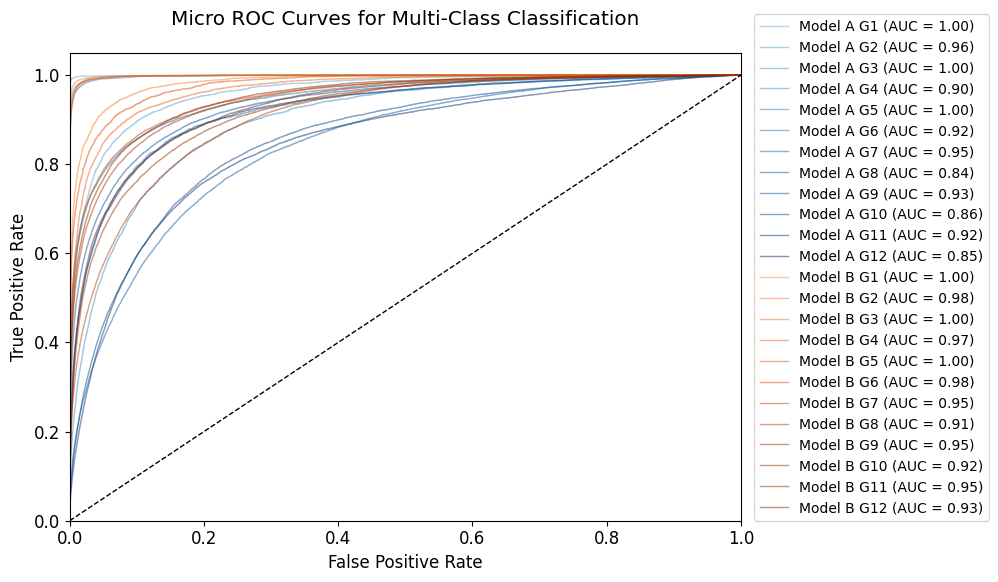

In [71]:
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(fpr, tpr, auc, model_name, group, color, linestyle='-', alpha=0.5):
    plt.plot(fpr, tpr,
             label=f'{model_name} G{group} (AUC = {auc:.2f})',
             color=color, linestyle=linestyle, linewidth=1, alpha=alpha)

plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 12})

# Generate colors for Model A and Model B
colors_A = plt.cm.Blues(np.linspace(0.5, 1, 12))
colors_B = plt.cm.Oranges(np.linspace(0.5, 1, 12))

# Plot Model A ROC curves
for i in range(12):
    fpr, tpr, auc = result_dict_2[f'G{i+1}'][0]['micro'], result_dict_2[f'G{i+1}'][1]['micro'], result_dict_2[f'G{i+1}'][2]['micro']
    plot_roc_curve(fpr, tpr, auc, 'Model A', i+1, colors_A[i])

# Plot Model B ROC curves
for i in range(12):
    fpr, tpr, auc = result_dict_1[f'G{i+1}'][0]['micro'], result_dict_1[f'G{i+1}'][1]['micro'], result_dict_1[f'G{i+1}'][2]['micro']
    plot_roc_curve(fpr, tpr, auc, 'Model B', i+1, colors_B[i])

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro ROC Curves for Multi-Class Classification', pad=20)

# Place the legend outside the plot area and adjust column width
legend = plt.legend(loc="lower left", bbox_to_anchor=(1.02, 0), fontsize='small', ncol=1, borderaxespad=0)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the padding to accommodate the legend
plt.savefig('roc_curves_paper.png', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()


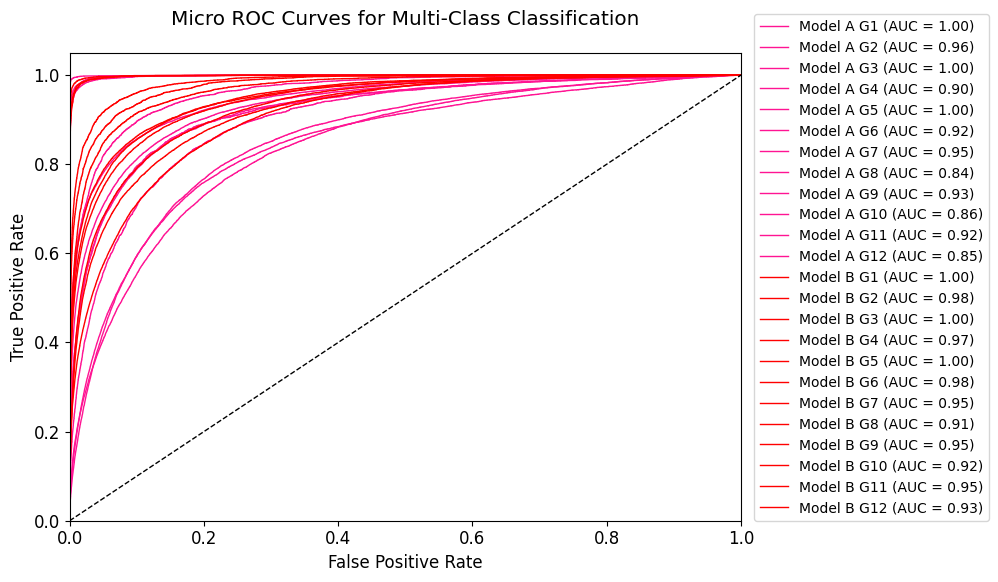

In [60]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, auc, model_name, group, color, linestyle='-'):
    plt.plot(fpr, tpr,
             label=f'{model_name} G{group} (AUC = {auc:.2f})',
             color=color, linestyle=linestyle, linewidth=1)

plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 12})

# Plot Model A ROC curves
for i in range(12):
    fpr, tpr, auc = result_dict_2[f'G{i+1}'][0]['micro'], result_dict_2[f'G{i+1}'][1]['micro'], result_dict_2[f'G{i+1}'][2]['micro']
    plot_roc_curve(fpr, tpr, auc, 'Model A', i+1, 'deeppink')

# Plot Model B ROC curves
for i in range(12):
    fpr, tpr, auc = result_dict_1[f'G{i+1}'][0]['micro'], result_dict_1[f'G{i+1}'][1]['micro'], result_dict_1[f'G{i+1}'][2]['micro']
    plot_roc_curve(fpr, tpr, auc, 'Model B', i+1, 'red')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro ROC Curves for Multi-Class Classification', pad=20)

# Place the legend outside the plot area and adjust column width
legend = plt.legend(loc="lower left", bbox_to_anchor=(1.02, 0), fontsize='small', ncol=1, borderaxespad=0)
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the padding to accommodate the legend
plt.savefig('roc_curves_paper.png', dpi=300, bbox_extra_artists=(legend,), bbox_inches='tight')
plt.show()


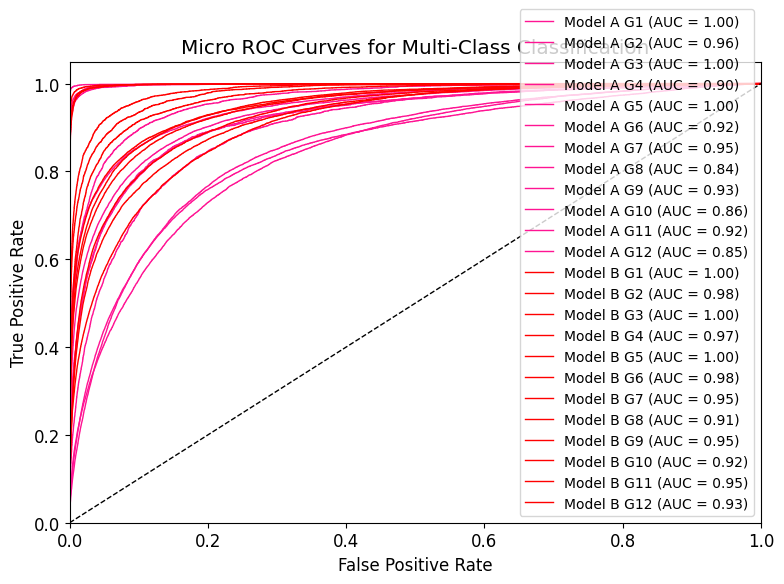

In [57]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, auc, model_name, group, color, linestyle='-'):
    plt.plot(fpr, tpr,
             label=f'{model_name} G{group} (AUC = {auc:.2f})',
             color=color, linestyle=linestyle, linewidth=1)

plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 12})

# Plot Model A ROC curves
for i in range(12):
    fpr, tpr, auc = result_dict_2[f'G{i+1}'][0]['micro'], result_dict_2[f'G{i+1}'][1]['micro'], result_dict_2[f'G{i+1}'][2]['micro']
    plot_roc_curve(fpr, tpr, auc, 'Model A', i+1, 'deeppink')

# Plot Model B ROC curves
for i in range(12):
    fpr, tpr, auc = result_dict_1[f'G{i+1}'][0]['micro'], result_dict_1[f'G{i+1}'][1]['micro'], result_dict_1[f'G{i+1}'][2]['micro']
    plot_roc_curve(fpr, tpr, auc, 'Model B', i+1, 'red')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro ROC Curves for Multi-Class Classification')
plt.legend(loc="lower right", fontsize='small')
plt.tight_layout()
plt.savefig('roc_curves_paper.png', dpi=300)
plt.show()


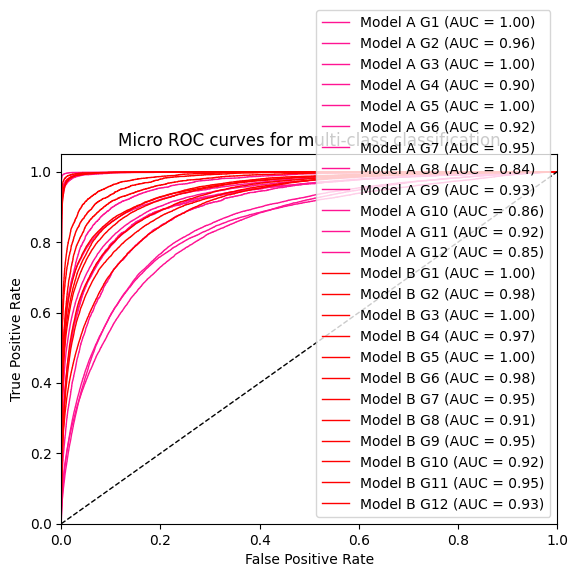

In [56]:
# Plot micro and macro ROC curves
plt.figure()

for i in range(12):
    plt.plot(result_dict_2['G%d'%(i+1)][0]['micro'], result_dict_2['G%d'%(i+1)][1]['micro'],
            label='Model A G{0:d} (AUC = {1:0.2f})'.format(i+1, result_dict_2['G%d'%(i+1)][2]['micro']),
            color='deeppink', linestyle='-', linewidth=1)

for i in range(12):
    plt.plot(result_dict_1['G%d'%(i+1)][0]['micro'], result_dict_1['G%d'%(i+1)][1]['micro'],
            label='Model B G{0:d} (AUC = {1:0.2f})'.format(i+1, result_dict_1['G%d'%(i+1)][2]['micro']),
            color='red', linestyle='-', linewidth=1)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro ROC curves for multi-class classification')
plt.legend(loc="lower right")
plt.show()

## Playground

In [34]:
# generate random y_test
y_test = np.random.randint(0, 3, size=100)

# generate random y_score for 3 classes, which sum to 1.0
y_score = np.random.rand(100, 3)
y_score /= y_score.sum(axis=1)[:, np.newaxis]


# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

In [36]:
fpr, tpr, _ = roc_curve(y_test_bin[:, 0], y_score[:, 0])

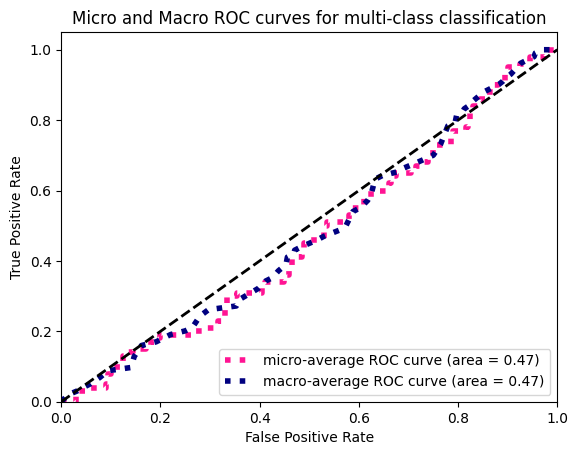

In [39]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt

# Assuming you have X_train, X_test, y_train, y_test, and a classifier called 'clf'

# generate random y_test
y_test = np.random.randint(0, 3, size=100)

# generate random y_score for 3 classes, which sum to 1.0
y_score = np.random.rand(100, 3)
y_score /= y_score.sum(axis=1)[:, np.newaxis]


# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# # Train a OneVsRestClassifier using your classifier
# ovr_clf = OneVsRestClassifier(clf)
# y_score = ovr_clf.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot micro and macro ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro and Macro ROC curves for multi-class classification')
plt.legend(loc="lower right")
plt.show()


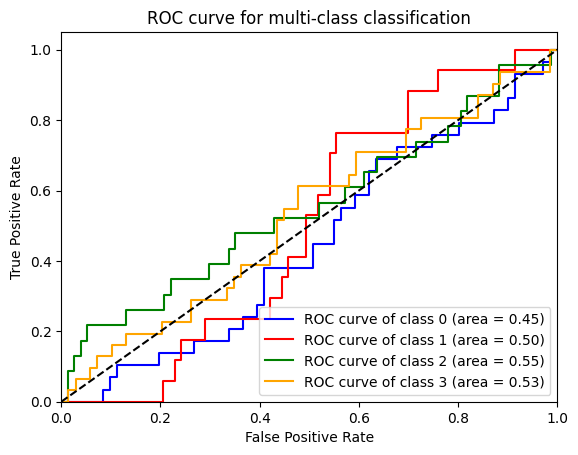

In [13]:
# 导入所需库
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 随机生成数据
n_classes = 4 # 类别数
n_samples = 100 # 样本数
y_true = np.random.randint(0, n_classes, size=n_samples) # 真实标签
y_score = np.random.rand(n_samples, n_classes) # 预测概率

# 将标签和概率二值化
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))
y_score_bin = y_score / y_score.sum(axis=1)[:, np.newaxis]

# 计算每个类别的fpr和tpr
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制roc曲线
plt.figure()
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for multi-class classification')
plt.legend(loc="lower right")
plt.show()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.541


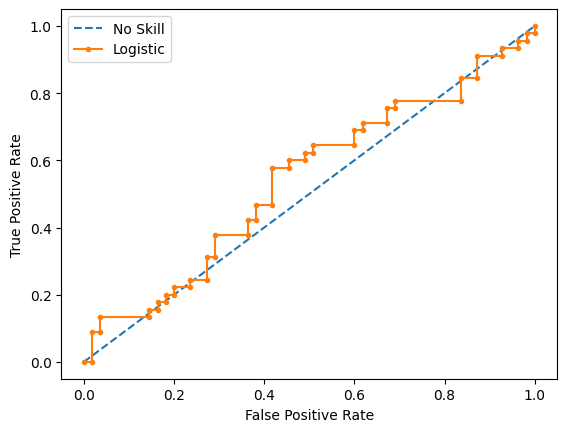

In [1]:
# draw binary classification roc curve demo
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# generate random y_test
from numpy import random
y_test = random.randint(3, size=100)

# generate a no skill prediction (majority class)
# ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
# lr_probs = model.predict_proba(X_test)

# generate random lr_probs
lr_probs = random.rand(len(y_test), 3)
 
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
# ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


In [ ]:
# draw binary classification curve demo
import numpy as np
import matplotlib.pyplot as plt


def draw_binary_classification_curve_demo():
    # generate 2 class dataset
    mean1 = [1, 20]
    cov1 = [[1, 1], [1, 2]]
    x1, y1 = np.random.multivariate_normal(mean1, cov1, 1000).T
    mean2 = [20, 1]
    cov2 = [[2, 1], [1, 1]]
    x2, y2 = np.random.multivariate_normal(mean2, cov2, 1000).T

    # draw scatter plot
    plt.scatter(x1, y1, c='r', marker='x')
    plt.scatter(x2, y2, c='b', marker='o')

    # draw binary classification curve
    x = np.linspace(0, 20, 100)
    y = 0.5 * x + 10
    plt.plot(x, y, c='g')

    plt.show()


In [ ]:
# # %%
# import pickle

# for i in range(12):
#     feats, labels = evaluateFromList(model, "../flearn_data/G%d_ID/train_list_G%d_ID.txt"%(i+1,i+1))

#     # save python objects feats and labels
#     with open('../FL_log/feats_G%d_ID.pkl'%i, 'wb') as f:
#         pickle.dump(feats, f)
#     with open('../FL_log/labels_G%d_ID.pkl'%i, 'wb') as f:
#         pickle.dump(labels, f)
